In [1]:
from datetime import datetime 
# start_time = datetime.now()     uncomment this to calculate total execution+ verification time

In [2]:
import hashlib
import os
import random
class PinocchioProofProtocol:
    def __init__(self):
        # Initialize the Pinocchio proof protocol 
        pass

    @staticmethod
    def proving_scheme(computation):
        # Generate proving key and verification key
        return "proving_key", "verification_key"

    @staticmethod
    def verification_scheme(verification_key, proof, input_data):
        return True  

    def generate_proof(self, computation, input_data, evaluation_key):
        proving_key, _ = PinocchioProofProtocol.proving_scheme(computation)
        proof = ZKProof(input_data).generate_proof(input_data)  # Using ZKProof for generating proof
        return proof

    def verify_proof(self, computation, vk, proof, input_data):
        #  implementation  using cryptographic libraries
        _, verification_key = PinocchioProofProtocol.proving_scheme(computation)
        verification_result = ZKProof(proof).verify(proof)  # Using ZKProof for verification
        return verification_result

class ZKProof:
    def __init__(self,proof):
        self.N = 20
        self.salt = os.urandom(16)
        self.v=self._hash(proof)
        

    def _hash(self, x):
        return hashlib.sha256(x.encode('utf-8') + self.salt).hexdigest()

    def generate_proof(self, secret):
        self.secret = secret
        self.v = self._hash(secret)
        r = str(random.randint(1, self.N))
        self.x = self._hash(r)
        return self.x

    def get_secret(self):
        return self.secret

    def verify(self, response):
        return self.v == self._hash(response)



In [3]:
import sqlparse
import re



class VFuzzCompiler:
    def __init__(self, privacy_budget):
        self.privacy_budget = privacy_budget

    def type_check_query(self, query):
        try:
            # Check if the query is well-formed
            self._check_well_formed(query)

            # Check if the query adheres to privacy budget
            self._check_privacy_budget(query)

            print("Query is differentially private and type-checked.")
            return True
        except Exception as e:
            print(f"Error: {e}")

    def _check_well_formed(self, query):
        # well-formedness check
        # Check if "map" and "split" are present in the query
        if "map" not in query and "split" not in query:
            raise ValueError("Query is not well-formed.")

    def _check_privacy_budget(self, query):
        
        privacy_cost = self._calculate_privacy_cost(query)

        if privacy_cost > self.privacy_budget:
            raise ValueError("Query exceeds privacy budget.")

    def _calculate_privacy_cost(self, query):
        # type of operations and sensitivity of the data involved

       
        operation_privacy_costs = {
            "map": 1,
            "count": 2,
            "split": 1,
            "sum": 2
          
        }

        #  privacy cost based on the operations 
        privacy_cost = sum(operation_privacy_costs.get(op, 0) for op in query)

        return privacy_cost

    def convert_sql_to_vfuzz_query(self,sql_query):
    

        # Parse the SQL query
        parsed_query = sqlparse.parse(sql_query)[0]

        
        vfuzz_query = []

       
        for token in parsed_query.tokens:
            vfuzz_operation = None  
            

           
            if token.normalized.lower() in {"select", "*"}:
                vfuzz_query.append("map")
            if re.match(r"^count\((.+)\)$", token.normalized.lower()):
                field_name = re.match(r"^count\((.+)\)$", token.normalized.lower()).group(1)
                vfuzz_query.append("count")
            if re.match(r"^avg\((.+)\)$", token.normalized.lower()):
                field_name = re.match(r"^avg\((.+)\)$", token.normalized.lower()).group(1)
                vfuzz_query.append("sum")  # Note: Using "sum" as suggested for "avg"
            if re.match(r"^where (.*)$", token.normalized.lower()):
                where_clause = re.match(r"^where (.*)$", token.normalized.lower()).group(1)
                vfuzz_query.append("split")

            
                

        return vfuzz_query



In [4]:
class VFuzzInterpreter:
    @staticmethod
    def execute_green(query, laplace_noise, db_commitment):

        # we add Laplace noise to the commitment
        green_result = np.add(laplace_noise, db_commitment)
        return green_result

# vfuzz_interpreter module or class

class vfuzz_interpreter:
    @staticmethod
    def execute_green(query, laplace_noise, db_commitment):
        return VFuzzInterpreter.execute_green(query, laplace_noise, db_commitment)


In [5]:
import hashlib
import hmac
import numpy as np

class VerDPVerifier:
    def __init__(self):
        self.vfuzz_compiler = VFuzzCompiler(privacy_budget=24000.0)
        self.pinocchio_proof_protocol = PinocchioProofProtocol()

    def verify_computation(self, db_commitment, queries, vk, query_indices, proof):
        # Step 1: Verify the commitment to the dataset
        if not self.verify_commitment(db_commitment).all:
            return False

        for query, query_index in zip(queries, query_indices):
            # Step 2: Type-check the query using VFuzz compiler
            vfuzz_query = self.vfuzz_compiler.convert_sql_to_vfuzz_query(query)
            print(vfuzz_query)

            if not self.vfuzz_compiler.type_check_query(vfuzz_query):
                return False

            # Step 3: Verify the Pinocchio proof for each query
            if not self.verify_pinocchio_proof(query, vk, proof):
                return False

            # Step 4: Verify the Laplace noise and green portion of the query
            if not self.verify_laplace_noise_and_green(query, db_commitment):
                return False

        # All verifications passed successfully
        return True

    def verify_commitment(self, db_commitment):
        
        # Recompute the commitment using HMAC
        recomputed_commitment = hmac.new(b'secure_secret_key', msg=db.encode(), digestmod=hashlib.sha256).hexdigest()
        # Compare the provided commitment with the recomputed commitment
        recomputed_commitment_array=np.array([int(ch, 16) for ch in recomputed_commitment], dtype=np.uint8)
        return db_commitment == recomputed_commitment_array

    def verify_pinocchio_proof(self, query, vk, proof):
        
        # Implementation of Pinocchio proof verification
        input_data = 'secure_secret_key'
        verification_result = self.pinocchio_proof_protocol.verify_proof("computation", "verification_key",proof, input_data)
        print('Verified proof:', verification_result)
        return self.pinocchio_proof_protocol.verify_proof(query, vk, proof,input_data)

    def verify_laplace_noise_and_green(self, query, db_commitment):
        
        #  Laplace noise 
        laplace_noise = np.random.laplace(loc=0, scale=1, size=len(db_commitment))

        # Execute the green portion of the query
        green_result = vfuzz_interpreter.execute_green(query, laplace_noise, db_commitment)
        return True  


In [6]:
import csv
import random

def read_csv_schema(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        schema = {'tables': {}}
        for row in reader:
            table_name = row[0]
            columns = row[1:]
            schema['tables'][table_name] = columns
        return schema

def generate_random_sql_query(schema):
    table = random.choice(list(schema['tables']))
    columns = random.sample(schema['tables'][table], random.randint(1, len(schema['tables'][table])))
    query = f"SELECT {', '.join(columns)} FROM {table}"

   
    if random.choice([True, False]):
        condition_column = random.choice(columns)
        condition_value = f"'{random.choice(['value1', 'value2', 'value3'])}'"
        query += f" WHERE {condition_column} = {condition_value}"

    
    if random.choice([True, False]):
        group_by_column = random.choice(columns)
        query += f" GROUP BY {group_by_column}"

        # aggregate functions (SUM, AVG, COUNT) to the query
        aggregate_function = random.choice(['SUM', 'AVG', 'COUNT'])
        aggregate_column = random.choice(columns)
        query += f" {aggregate_function}({aggregate_column})"

   
    if random.choice([True, False]):
        order_by_column = random.choice(columns)
        query += f" ORDER BY {order_by_column}"

    
    if random.choice([True, False]):
        limit = random.randint(1, 10)
        query += f" LIMIT {limit}"

    return query


csv_file_path = './employees.csv'
database_schema = read_csv_schema(csv_file_path)


queries = []
num_queries = 16000
for _ in range(num_queries):
    random_sql_query = generate_random_sql_query(database_schema)
    queries.append(random_sql_query)


print("queries = [")
for query in queries:
    print(f'    "{query}",')
print("]")


queries = [
    "SELECT 910.407.8536x8933, adammartinez279637@slingacademy.com, 11500, Martinez, 9 FROM Adam GROUP BY 11500 SUM(11500) LIMIT 9",
    "SELECT 29 FROM Stephen WHERE 29 = 'value2' ORDER BY 29 LIMIT 7",
    "SELECT +1-160-924-8899x786, 38, 12000, 14 FROM Breanna LIMIT 3",
    "SELECT Product, Mobile Developer, 018.297.6175x4163, 32 FROM Robert GROUP BY 018.297.6175x4163 SUM(32) ORDER BY 018.297.6175x4163",
    "SELECT dianecarter1228@slingacademy.com, 26, Machine Learning Engineer, Product, 7000 FROM Diane GROUP BY 26 SUM(26) ORDER BY Product LIMIT 4",
    "SELECT 9500, Richardson FROM Melissa ORDER BY 9500",
    "SELECT 6500, eringreen243810@slingacademy.com, Product, 1, Green, 765-014-8238x735, 23, female FROM Erin WHERE Green = 'value3' GROUP BY Green SUM(Product) ORDER BY Green",
    "SELECT Mcpherson, 5, 28, beckymcpherson172514@slingacademy.com, 7500, Web Developer FROM Becky ORDER BY 28 LIMIT 9",
    "SELECT Product, Web Developer, Sanders FROM Damon GROUP BY Sanders

In [7]:
# Secret key for HMAC 
secret_key = 'secure_secret_key'



import csv
import json





csv_file_path = "./employees.csv"  

sample_dataset = []

with open(csv_file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        sample_dataset.append(row)



db = json.dumps(sample_dataset)
db_commitment = hmac.new(b'secure_secret_key', msg=db.encode(), digestmod=hashlib.sha256).hexdigest()



vk = "sample_verification_key"


query_indices = list(range(1, num_queries + 1))  

# proofs 
# proofs = []
# for i in range(1, num_queries + 1):
#         proof = f"sample_proof_query{i}"  # Sample proof for each query
#         proofs.append(proof)
pinocchio_proof_protocol = PinocchioProofProtocol()
secret_card =secret_key
proof =pinocchio_proof_protocol.generate_proof("computation", secret_card, "evaluation_key")

print('Pinocchio Proof:', proof)


verifier = VerDPVerifier()
db_commitment_array = np.array([int(ch, 16) for ch in db_commitment], dtype=np.uint8)
start_time = datetime.now()     #  calculate only verification time

result = verifier.verify_computation(db_commitment_array , queries, vk, query_indices, proof)

if result:
    print("Computation verified successfully!")
else:
    print("Computation verification failed.")
    
    
end_time = datetime.now() 
  
time_difference = (end_time - start_time).total_seconds() * 10**3
print("Execution time of program is: ", time_difference, "ms") 


Pinocchio Proof: 5b51840723d931405a8194747442fdb60bce70f43f92412488762e81166a1e16
['map']
Query is differentially private and type-checked.
Verified proof: True
['map', 'split']
Query is differentially private and type-checked.
Verified proof: True
['map']
Query is differentially private and type-checked.
Verified proof: True
['map']
Query is differentially private and type-checked.
Verified proof: True
['map']
Query is differentially private and type-checked.
Verified proof: True
['map']
Query is differentially private and type-checked.
Verified proof: True
['map', 'split']
Query is differentially private and type-checked.
Verified proof: True
['map']
Query is differentially private and type-checked.
Verified proof: True
['map', 'sum']
Query is differentially private and type-checked.
Verified proof: True
['map', 'split', 'count']
Query is differentially private and type-checked.
Verified proof: True
['map', 'split', 'count']
Query is differentially private and type-checked.
Verified 

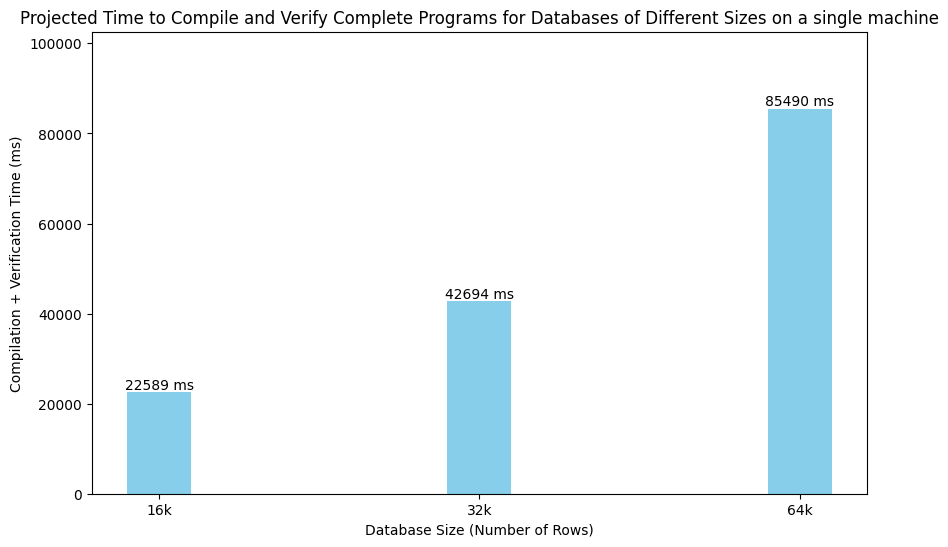

In [8]:
import matplotlib.pyplot as plt

# Execution time(in milliseconds)
execution_times = {
    '16k': 22588.714,
    '32k': 42694.007,
    '64k': 85490.156 
}

# Extracting sizes and times
sizes = list(execution_times.keys())
times = list(execution_times.values())


plt.figure(figsize=(10, 6))
plt.bar(sizes, times, color='skyblue',width=0.2)

plt.xlabel('Database Size (Number of Rows)')
plt.ylabel('Compilation + Verification Time (ms)')
plt.title('Projected Time to Compile and Verify Complete Programs for Databases of Different Sizes on a single machine')
plt.ylim(0, max(times) * 1.2)  

# Adding the values on top of the bars
for i in range(len(sizes)):
    plt.text(i, times[i], f'{times[i]:.0f} ms', ha='center', va='bottom')

plt.show()


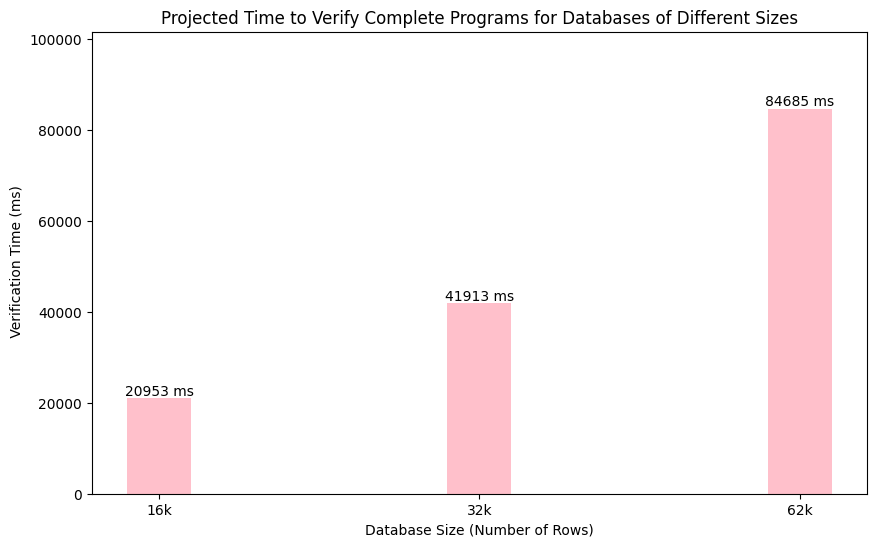

In [9]:
import matplotlib.pyplot as plt

# Verification time(in milliseconds)
execution_times = {
    '16k': 20953.095,
    '32k': 41912.688,
    '62k': 84685.14 
}

sizes = list(execution_times.keys())
times = list(execution_times.values())


plt.figure(figsize=(10, 6))
plt.bar(sizes, times, color='pink',width=0.2)

plt.xlabel('Database Size (Number of Rows)')
plt.ylabel(' Verification Time (ms)')
plt.title('Projected Time to Verify Complete Programs for Databases of Different Sizes')
plt.ylim(0, max(times) * 1.2)  

for i in range(len(sizes)):
    plt.text(i, times[i], f'{times[i]:.0f} ms', ha='center', va='bottom')

plt.show()
